<h1 style='color: green; font-size: 26px; font-weight: bold;'> 2. Similiaridade entre produtos <h1>

Un desafío constante en MELI es el de poder agrupar productos similares utilizando algunos
atributos de estos como pueden ser el título, la descripción o su imagen.
Para este desafío tenemos un dataset “items_titles.csv” que tiene títulos de 30 mil productos de 3 categorías diferentes de Mercado Libre Brasil

<strong>Entregable</strong>
El objetivo del desafío es poder generar una Jupyter notebook que determine cuán similares son dos títulos
del dataset “item_titles_test.csv” generando como output un listado de la forma


<p></p>

<table>
    <thread>
        <tr>
            <th> ITE_ITEM_TITLE </th>
            <th> ITE_ITEM_TITLE </th>
            <th> Score Similitud (0,1) </th>
        </tr>
    </thread>
    <tbody>
        <tr>
            <td> Zapatillas Nike</td>
            <td> Zapatillas Adidas </td>
            <td> 0.5</td>
        </tr>
        <tr>
            <td> Zapatillas Nike</td>
            <td> Zapatillas Nike</td>
            <td> 1</td>
        </tr>
    </tbody>
</table>

donde ordenando por score de similitud podamos encontrar los pares de productos más
similares en nuestro dataset de test

In [17]:
import pandas as pd
import os
import glob
import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\barba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
dir_data = "F:\PycharmProjects\DesaioMELI\data"
df_train = pd.read_csv(dir_data+'\items_titles.csv')
df_test = pd.read_csv(dir_data+'\items_titles_test.csv')

In [19]:
df_train.head(5)

,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Verme...
1,Tenis Para Caminhada Super Levinho Spider Corr...
2,Tênis Feminino Le Parc Hocks Black/ice Origina...
3,Tênis Olympikus Esportivo Academia Nova Tendên...
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...


análise inicial

In [20]:
df_train.shape

(30000, 1)

In [21]:
df_train.describe()

,ITE_ITEM_TITLE
count,30000
unique,30000
top,Tênis Ascension Posh Masculino - Preto E Verme...
freq,1


# Feature Engineering

## Limpeza do corpus

In [22]:
def unigram_list(df,colum):
    """ Forma a lista de unigramas somente com palavras e transforma todos os itens da lista em lower case """
    df[colum] = df[colum].str.lower()
    regexp = RegexpTokenizer('\w+')
    df['unigrama_' + colum] = df[colum].apply(regexp.tokenize)

In [23]:
unigram_list(df_train, 'ITE_ITEM_TITLE')

In [24]:
df_train.head()

,ITE_ITEM_TITLE,unigrama_ITE_ITEM_TITLE
0,tênis ascension posh masculino - preto e verme...,"[tênis, ascension, posh, masculino, preto, e, ..."
1,tenis para caminhada super levinho spider corr...,"[tenis, para, caminhada, super, levinho, spide..."
2,tênis feminino le parc hocks black/ice origina...,"[tênis, feminino, le, parc, hocks, black, ice,..."
3,tênis olympikus esportivo academia nova tendên...,"[tênis, olympikus, esportivo, academia, nova, ..."
4,inteligente led bicicleta tauda luz usb bicicl...,"[inteligente, led, bicicleta, tauda, luz, usb,..."


### Acentuação, cedilha e caracteres especiais


In [25]:
def retira_acentuacao(df, colum):
    """ Retira acentuação e cedilha  """
    letras_com_ascento = "éèëêáàãâíìîúûùóòôõçñ"
    letras_sem_ascento = "eeeeaaaaiiiuuuoooocn"

    palavra_sem_acento = []
    texto_sem_acento = []
    id = 0
    dict_texto = {}
    for word in df[colum]:
        if type(word) is list: # Se for uma lista de palavras
            for j in word:
                tabela_substituicao = j.maketrans(letras_com_ascento,letras_sem_ascento)
                palavra_sem_acento.append(j.translate(tabela_substituicao))
            texto_sem_acento.append(palavra_sem_acento)
            palavra_sem_acento = []
        else:
            tabela_substituicao = word.maketrans(letras_com_ascento,letras_sem_ascento)
            texto_sem_acento.append(word.translate(tabela_substituicao))

    for i in texto_sem_acento:
        dict_texto[id] = i
        id = id + 1

    df[colum] = df[colum].index.map(dict_texto)
    return df[colum]

In [26]:
df_train['ITE_ITEM_TITLE_CLEAN'] = retira_acentuacao(df_train, 'unigrama_ITE_ITEM_TITLE')

In [27]:
df_train.sample(5)

,ITE_ITEM_TITLE,unigrama_ITE_ITEM_TITLE,ITE_ITEM_TITLE_CLEAN
19950,tênis infantil bibi fisioflex 4.0 fem azul est...,"[tenis, infantil, bibi, fisioflex, 4, 0, fem, ...","[tenis, infantil, bibi, fisioflex, 4, 0, fem, ..."
10784,sapatênis feminino tênis branco estrela dourad...,"[sapatenis, feminino, tenis, branco, estrela, ...","[sapatenis, feminino, tenis, branco, estrela, ..."
12249,tênis puma red bull racing disc cinza tam 41,"[tenis, puma, red, bull, racing, disc, cinza, ...","[tenis, puma, red, bull, racing, disc, cinza, ..."
3757,tênis branco strass prata presente,"[tenis, branco, strass, prata, presente]","[tenis, branco, strass, prata, presente]"
23665,sapatilha bicicleta absolute feminina luna mtb...,"[sapatilha, bicicleta, absolute, feminina, lun...","[sapatilha, bicicleta, absolute, feminina, lun..."


### Stopwords

In [28]:
stopwords = pd.read_csv('.\stopwords.txt', header=None)
stopwords.rename(columns={0: 'palavras'}, inplace=True)

In [29]:
stopwords['palavras_sem_ascento'] = retira_acentuacao(stopwords,'palavras')

In [30]:
def remove_stopwords(df, colum):
   return df[colum].apply(lambda x: [word.lower() for word in x if word.lower() not in list(stopwords['palavras_sem_ascento'])])

In [31]:
def final_colum(df,colum):
    new_colum  = colum + '_FINAL'
    df[new_colum] = remove_stopwords(df,colum)
    #unificar as palavras da lista
    df[new_colum]  = df[new_colum] .str.join(' ')
    return df

In [32]:
final_colum(df_train,'ITE_ITEM_TITLE_CLEAN')

,ITE_ITEM_TITLE,unigrama_ITE_ITEM_TITLE,ITE_ITEM_TITLE_CLEAN,ITE_ITEM_TITLE_CLEAN_FINAL
0,tênis ascension posh masculino - preto e verme...,"[tenis, ascension, posh, masculino, preto, e, ...","[tenis, ascension, posh, masculino, preto, e, ...",tenis ascension posh masculino preto vermelho
1,tenis para caminhada super levinho spider corr...,"[tenis, para, caminhada, super, levinho, spide...","[tenis, para, caminhada, super, levinho, spide...",tenis caminhada super levinho spider corrida
2,tênis feminino le parc hocks black/ice origina...,"[tenis, feminino, le, parc, hocks, black, ice,...","[tenis, feminino, le, parc, hocks, black, ice,...",tenis feminino le parc hocks black ice origina...
3,tênis olympikus esportivo academia nova tendên...,"[tenis, olympikus, esportivo, academia, nova, ...","[tenis, olympikus, esportivo, academia, nova, ...",tenis olympikus esportivo academia nova tenden...
4,inteligente led bicicleta tauda luz usb bicicl...,"[inteligente, led, bicicleta, tauda, luz, usb,...","[inteligente, led, bicicleta, tauda, luz, usb,...",inteligente led bicicleta tauda luz usb bicicl...
...,...,...,...,...
29995,tênis vans old skool i love my vans - usado - ...,"[tenis, vans, old, skool, i, love, my, vans, u...","[tenis, vans, old, skool, i, love, my, vans, u...",tenis vans old skool i love my vans usado femi...
29996,tênis feminino preto moleca 5296155,"[tenis, feminino, preto, moleca, 5296155]","[tenis, feminino, preto, moleca, 5296155]",tenis feminino preto moleca 5296155
29997,tenis botinha com pelo via marte original lanç...,"[tenis, botinha, com, pelo, via, marte, origin...","[tenis, botinha, com, pelo, via, marte, origin...",tenis botinha via marte original lancamento
29998,tênis slip on feminino masculino original sapa...,"[tenis, slip, on, feminino, masculino, origina...","[tenis, slip, on, feminino, masculino, origina...",tenis slip on feminino masculino original sapa...


# Similaridade

## Similaridade cosseno com Embedding Matrix

In [33]:
#Dados de teste
unigram_list(df_test,'ITE_ITEM_TITLE')
df_test['ITE_ITEM_TITLE_CLEAN'] = retira_acentuacao(df_test, 'unigrama_ITE_ITEM_TITLE')
unigram_list(df_test, 'ITE_ITEM_TITLE')
final_colum(df_test,'ITE_ITEM_TITLE_CLEAN')

,ITE_ITEM_TITLE,unigrama_ITE_ITEM_TITLE,ITE_ITEM_TITLE_CLEAN,ITE_ITEM_TITLE_CLEAN_FINAL
0,tênis olympikus esporte valente - masculino kids,"[tênis, olympikus, esporte, valente, masculino...","[tenis, olympikus, esporte, valente, masculino...",tenis olympikus esporte valente masculino kids
1,bicicleta barra forte samy c/ 6 marchas cubo c...,"[bicicleta, barra, forte, samy, c, 6, marchas,...","[bicicleta, barra, forte, samy, c, 6, marchas,...",bicicleta barra forte samy c 6 marchas cubo c ...
2,tênis usthemp slip-on temático - labrador 2,"[tênis, usthemp, slip, on, temá, tico, labrado...","[tenis, usthemp, slip, on, tema, tico, labrado...",tenis usthemp slip on tema tico labrador 2
3,tênis casual feminino moleca tecido tie dye,"[tênis, casual, feminino, moleca, tecido, tie,...","[tenis, casual, feminino, moleca, tecido, tie,...",tenis casual feminino moleca tecido tie dye
4,tênis star baby sapatinho conforto + brinde,"[tênis, star, baby, sapatinho, conforto, brinde]","[tenis, star, baby, sapatinho, conforto, brinde]",tenis star baby sapatinho conforto brinde
...,...,...,...,...
9995,chuteira futsal oxn velox 3 infantil,"[chuteira, futsal, oxn, velox, 3, infantil]","[chuteira, futsal, oxn, velox, 3, infantil]",chuteira futsal oxn velox 3 infantil
9996,sapatenis casual masculino estiloso 24horas co...,"[sapatenis, casual, masculino, estiloso, 24hor...","[sapatenis, casual, masculino, estiloso, 24hor...",sapatenis casual masculino estiloso 24horas co...
9997,tênis feminino infantil molekinha tie dye,"[tênis, feminino, infantil, molekinha, tie, dye]","[tenis, feminino, infantil, molekinha, tie, dye]",tenis feminino infantil molekinha tie dye
9998,tênis feminino leve barato ganhe 1 colchonete ...,"[tênis, feminino, leve, barato, ganhe, 1, colc...","[tenis, feminino, leve, barato, ganhe, 1, colc...",tenis feminino leve barato ganhe 1 colchonete ...


In [34]:
def find_similar_products(train_df, test_df, train_col,original_train_col, test_col, original_test_col, limiar, vector):
    # Convertendo as colunas de texto para uma matriz de frequência de palavras
    n = 1

    train_matrix = vector.fit_transform(train_df[train_col])
    test_matrix = vector.transform(test_df[test_col])

    # Calculando a similaridade entre os produtos do conjunto de treino e teste
    similarity_matrix = cosine_similarity(test_matrix, train_matrix)

    # Encontrando os produtos similares para cada item do conjunto de teste
    similar_product = []
    for i, row in test_df.iterrows():
        original_test_product = row[original_test_col]
        test_product = row[test_col]
        similar_indices = similarity_matrix[i].argsort()[::-1]
        for idx in similar_indices:
            original_train_product = train_df.iloc[idx][original_train_col]
            train_product = train_df.iloc[idx][train_col]
            similarity = similarity_matrix[i][idx]
            if similarity > limiar :
                similar_product.append({
                        'ITE_ITEM_TITLE_TEST': original_test_product,
                        'ITE_ITEM_TITLE': original_train_product,
                        'Score Similitud (0,1)': similarity
                })
                break
            # similar_product.append({
            #     'ITE_ITEM_TITLE_TEST': test_product
            #     ,'ITE_ITEM_TITLE': train_product
            #     ,'Score Similitud (0,1)': similarity
            # })
            # break
    # Retornando os resultados ordenados pelo grau de similaridade
    similar_product = pd.DataFrame(similar_product).sort_values(by='Score Similitud (0,1)').reset_index(drop=True)
    return similar_product

In [49]:
#passa os dados de treino e teste
similar_product = find_similar_products(df_train, df_test, 'ITE_ITEM_TITLE_CLEAN_FINAL','ITE_ITEM_TITLE', 'ITE_ITEM_TITLE_CLEAN_FINAL', 'ITE_ITEM_TITLE', 0, TfidfVectorizer(binary=True,  analyzer='word'))
similar_product.head(20)

,ITE_ITEM_TITLE_TEST,ITE_ITEM_TITLE,"Score Similitud (0,1)"
0,tênis molekinha tec thal/lyc prot/cam met cam,tenis infantil - molekinho - lyc neop - 2616.103,0.264255
1,mulheres senhoras confortável wedge mesh tênis...,tênis feminino napa sua cia ref 8082.11780,0.266504
2,mulheres plush flats shoes cor sólida dedo red...,sapatos esportivos mulheres slip on mocassim f...,0.273981
3,"spikes de sapato de neve zerodis, prático para...",sapato ferracini sapatenis masculino infinit n...,0.276461
4,modelos de kits de bicicleta pintados à mão co...,kits 2 tênis esportivo feminino academia corri...,0.279088
5,adaptador da montagem da montagem da tocha da ...,suporte para montagem de bicicleta na parede s...,0.284544
6,lace up shoe cover anti-smash waterproof shoe ...,sapatos femininos cover foot mesh soft sole sa...,0.295146
7,balança digital multilaser hc024 180 kg eastma...,smart tv multilaser 40 fhd lcd wifi usb conver...,0.295367
8,tênis plataforma customizado para noivas e fes...,tênis feminino confortável moleca p/ festas lo...,0.296730
9,tênis sapatênis mule roxo purple rain prince d...,tênis sapatênis mule colorido cores now united...,0.299836


In [36]:
#salva o resultado em um excel para melhor vizualização de todos os resultados
similar_product.to_excel('resultado_desafio2.xlsx', header=True)

### Metricas de Validação geral

In [37]:
def evaluate_model(similar_product, true_values_col):
    """ Função que avalia o desempenho do modelo de busca de produtos similares """

    # Calculando o número de produtos corretamente identificados
    num_correct = 0
    num_predicted = 0
    num_true = 0

    for i, row in similar_product.iterrows():
        predicted_product = row['ITE_ITEM_TITLE']
        true_products = similar_product[true_values_col][i]
        if type(true_products) != str:
            true_products = ", ".join(true_products)
        if predicted_product in true_products:
            num_correct += 1
        num_predicted += 1
        num_true += len(true_products.split(", "))

    # Calculando as métricas de avaliação
    precision = num_correct / num_predicted
    recall = num_correct / num_true
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Criando um dicionário com as métricas de avaliação
    eval_dict = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }
    return eval_dict


In [38]:
eval_dict = evaluate_model(similar_product, 'ITE_ITEM_TITLE_TEST')
eval_dict

{'precision': 0.17008504252126064,
 'recall': 0.1669449081803005,
 'f1_score': 0.16850034691247892}

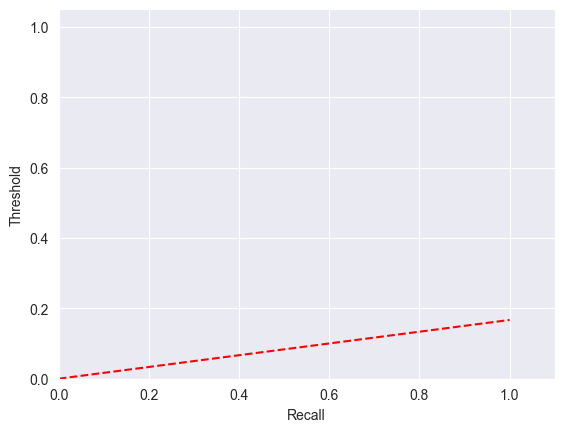

In [39]:
# Plotando o recall
plt.plot([0, 1], [0, eval_dict['recall']], 'r--')
plt.xlabel('Recall')
plt.ylabel('Threshold')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.1])
plt.show()


### Pipeline de processamento para cosseno

In [40]:
def pipeline_process_test(train, test, train_col, test_col, limiar, vector):
    # Limpeza dos dados
    unigram_list(train, train_col)
    train['ITE_ITEM_TITLE_CLEAN'] = retira_acentuacao(train, 'unigrama_ITE_ITEM_TITLE')
    final_colum(train,'ITE_ITEM_TITLE_CLEAN')

    #colunas sem a limpeza de dados, para o dataset final
    original_col = 'ITE_ITEM_TITLE'

   #Dados de teste
    unigram_list(test,test_col)
    test['ITE_ITEM_TITLE_CLEAN'] = retira_acentuacao(test, 'unigrama_ITE_ITEM_TITLE')
    final_colum(test,'ITE_ITEM_TITLE_CLEAN')

    # Encontrando os produtos similares
    similar_product = find_similar_products(train, test, train_col, original_col, test_col, original_col, limiar, vector)
    #salva o resultado em um excel para melhor vizualização de todos os resultados
    similar_product.to_excel('resultado_desafio2.xlsx', header=True)

    # #Desempenho geral (similaridade 'perfeita')
    # eval_dict = evaluate_model(similar_product, 'ITE_ITEM_TITLE_TEST')
    # print(eval_dict)
    # # Plotando o recall
    # plt.plot([0, 1], [0, eval_dict['recall']], 'r--')
    # plt.xlabel('Recall')
    # plt.ylabel('Threshold')
    # plt.ylim([0.0, 1.05])
    # plt.xlim([0.0, 1.1])
    # plt.show()
    return similar_product

pipeline_process_test(df_train, df_test, 'ITE_ITEM_TITLE', 'ITE_ITEM_TITLE', 0, TfidfVectorizer(binary=True, ty))


,ITE_ITEM_TITLE_TEST,ITE_ITEM_TITLE,"Score Similitud (0,1)"
0,tênis molekinha tec thal/lyc prot/cam met cam,tenis infantil - molekinho - lyc neop - 2616.103,0.258388
1,mulheres senhoras confortável wedge mesh tênis...,mulheres senhoras lazer malha slip-on wedges h...,0.264478
2,"spikes de sapato de neve zerodis, prático para...",apertos refletivos para botas de sapato de nev...,0.271333
3,mulheres plush flats shoes cor sólida dedo red...,sapatos esportivos mulheres slip on mocassim f...,0.273975
4,sandalia kemo com elastico pesca esporte nauti...,sapatênis infantil masculino motion azul nautico,0.276804
...,...,...,...
9991,tênis mizuno wave creation 22 preto rosé,tênis mizuno wave creation 22 preto rosé,1.000000
9992,tênis nike renew run 2 cu3504-002,tênis nike renew run 2 cu3504-002,1.000000
9993,rosa barato - últimas peças!,rosa barato - últimas peças!,1.000000
9994,tenis all star 04/2021 ct04950001 preto/bco,tenis all star 04/2021 ct04950001 preto/bco,1.000000


In [41]:
from gensim.parsing.preprocessing import strip_punctuation

In [42]:
df_train.head()

,ITE_ITEM_TITLE,unigrama_ITE_ITEM_TITLE,ITE_ITEM_TITLE_CLEAN,ITE_ITEM_TITLE_CLEAN_FINAL
0,tênis ascension posh masculino - preto e verme...,"[tenis, ascension, posh, masculino, preto, e, ...","[tenis, ascension, posh, masculino, preto, e, ...",tenis ascension posh masculino preto vermelho
1,tenis para caminhada super levinho spider corr...,"[tenis, para, caminhada, super, levinho, spide...","[tenis, para, caminhada, super, levinho, spide...",tenis caminhada super levinho spider corrida
2,tênis feminino le parc hocks black/ice origina...,"[tenis, feminino, le, parc, hocks, black, ice,...","[tenis, feminino, le, parc, hocks, black, ice,...",tenis feminino le parc hocks black ice origina...
3,tênis olympikus esportivo academia nova tendên...,"[tenis, olympikus, esportivo, academia, nova, ...","[tenis, olympikus, esportivo, academia, nova, ...",tenis olympikus esportivo academia nova tenden...
4,inteligente led bicicleta tauda luz usb bicicl...,"[inteligente, led, bicicleta, tauda, luz, usb,...","[inteligente, led, bicicleta, tauda, luz, usb,...",inteligente led bicicleta tauda luz usb bicicl...


##  Similaridade jaccard com Embedding Matrix

In [ ]:
import numpy as np


def calcular_similaridade_jaccard(texto1, texto2):
    s1 = set(texto1.split())
    s2 = set(texto2.split())

    return float(len(s1.intersection(s2)) / len(s1.union(s2)))
def similarity_matrix_batch(df1, col1, df2, col2, batch_size=1000):
    # Divide df1 em partes menores
    df1_batches = np.array_split(df1, len(df1) // batch_size + 1)

    result = pd.DataFrame()

    for df1_batch in df1_batches:
        # Merge os dataframes em cada parte
        df1_batch['_tmp'] = 1
        df2['_tmp'] = 1
        cartesian_product = pd.merge(df1_batch, df2, on='_tmp').drop('_tmp', axis=1)

        # Calcula a similaridade para cada par de linhas
        cartesian_product['similarity'] = cartesian_product.apply(lambda x: calcular_similaridade_jaccard(x[col1+'_x'], x[col2+'_y']), axis=1)

        # Concatena o resultado das partes
        result = pd.concat([result, cartesian_product[[col1+'_x', col2+'_y', 'similarity']]], ignore_index=True)

    # Renomeia as colunas e retorna o resultado final
    result.columns = [col1, col2, 'similarity']
    return result

#Calculate the similarity between each pair of rows
similarity_df = similarity_matrix_batch(df_test, 'ITE_ITEM_TITLE_CLEAN_FINAL', df_train, 'ITE_ITEM_TITLE_CLEAN_FINAL', batch_size=2000)


In [ ]:
similarity_df.head()

In [ ]:
similarity_df = similarity_df[similarity_df['similarity'] > 0.4]
similarity_df.to_excel("resultado_desafio2_jaccard.xlsx", header=True)

## Medindo o tempo de processamento e desempenho de cada técnica

In [46]:
import time

def execution_time():
    t01 = time.time()
    pipeline_process_test(df_train, df_test, 'ITE_ITEM_TITLE', 'ITE_ITEM_TITLE', 0, TfidfVectorizer(binary=True))
    t11 = time.time()
    timer1 = t11 - t01
    t02 = time.time()
    similarity_df =  similarity_matrix_batch(df_test, 'ITE_ITEM_TITLE_CLEAN_FINAL', df_train, 'ITE_ITEM_TITLE_CLEAN_FINAL', batch_size=2000)
    t12 = time.time()
    timer2 = t12 - t02
    # Criando um dicionário com as métricas de avaliação
    exec_time = {
        'cosseno': timer1,
        'jaccard': timer2,
    }
    print('Tempo de execução cosseno: {:.2f} segundos'.format(timer1))
    print('Tempo de execução jaccard: {:.2f} segundos'.format(timer2))
    return exec_time
execution_time()

Tempo de execução cosseno: 32.40 segundos
Tempo de execução jaccard: 2375.34 segundos


,ITE_ITEM_TITLE_CLEAN_FINAL,ITE_ITEM_TITLE_CLEAN_FINAL,similarity
0,tenis olympikus esporte valente masculino kids,tenis ascension posh masculino preto vermelho,0.200000
1,tenis olympikus esporte valente masculino kids,tenis caminhada super levinho spider corrida,0.090909
2,tenis olympikus esporte valente masculino kids,tenis feminino le parc hocks black ice origina...,0.071429
3,tenis olympikus esporte valente masculino kids,tenis olympikus esportivo academia nova tenden...,0.181818
4,tenis olympikus esporte valente masculino kids,inteligente led bicicleta tauda luz usb bicicl...,0.000000
...,...,...,...
299999995,tenis polo ralph lauren modelo cantor low bran...,tenis vans old skool i love my vans usado femi...,0.058824
299999996,tenis polo ralph lauren modelo cantor low bran...,tenis feminino preto moleca 5296155,0.076923
299999997,tenis polo ralph lauren modelo cantor low bran...,tenis botinha via marte original lancamento,0.071429
299999998,tenis polo ralph lauren modelo cantor low bran...,tenis slip on feminino masculino original sapa...,0.125000


In [ ]:
similarity_df = similarity_df.rename(columns={0: 'ITE_ITEM_TITLE_TEST', 1: 'ITE_ITEM_TITLE'}, inplace=True)


In [ ]:
similarity_df.head()